# tiny recursive model (TRM) - torch implementation

based on: "less is more: recursive reasoning with tiny networks"

**key architecture:**
- single tiny 2-layer network
- latent recursion: z = net(x, y, z) for n iterations
- answer update: y = net(y, z)
- deep supervision: carry (y, z) across supervision steps

## imports and setup

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# device setup
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cpu


## data preprocessing

In [2]:
class CharDataset(Dataset):
    """character-level dataset for language modeling"""
    
    def __init__(self, text, seq_len, char_to_idx=None):
        self.seq_len = seq_len
        
        # build vocab if not provided
        if char_to_idx is None:
            chars = sorted(set(text))
            self.char_to_idx = {c: i for i, c in enumerate(chars)}
            self.idx_to_char = {i: c for c, i in self.char_to_idx.items()}
        else:
            self.char_to_idx = char_to_idx
            self.idx_to_char = {i: c for c, i in char_to_idx.items()}
        
        self.vocab_size = len(self.char_to_idx)
        
        # encode text
        self.data = torch.tensor([self.char_to_idx[c] for c in text], dtype=torch.long)
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + 1:idx + self.seq_len + 1]
        return x, y

## model components

In [3]:
class RMSNorm(nn.Module):
    """root mean square layer normalization"""
    
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return (x / rms) * self.weight


class SwiGLU(nn.Module):
    """swiglu feedforward: swish(x @ w_gate) * (x @ w_up) @ w_down"""
    
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w_gate = nn.Linear(dim, hidden_dim, bias=bias)
        self.w_up = nn.Linear(dim, hidden_dim, bias=bias)
        self.w_down = nn.Linear(hidden_dim, dim, bias=bias)
    
    def forward(self, x):
        gate = F.silu(self.w_gate(x))  # silu = swish
        up = self.w_up(x)
        return self.w_down(gate * up)


class MLPMixer(nn.Module):
    """mlp applied on sequence dimension (token mixing)"""
    
    def __init__(self, seq_len, hidden_mult=1):
        super().__init__()
        hidden = seq_len * hidden_mult
        self.fc1 = nn.Linear(seq_len, hidden)
        self.fc2 = nn.Linear(hidden, seq_len)
    
    def forward(self, x):
        # x: [batch, seq, dim]
        x = x.transpose(1, 2)  # [batch, dim, seq]
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x.transpose(1, 2)  # [batch, seq, dim]

In [4]:
class TRMBlock(nn.Module):
    """
    single trm block: norm -> mixer -> norm -> swiglu ffn
    with residual connections
    """
    
    def __init__(self, dim, hidden_dim, seq_len, use_attention=False):
        super().__init__()
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        
        if use_attention:
            # simple single-head attention
            self.mixer = nn.MultiheadAttention(dim, num_heads=4, batch_first=True, bias=False)
            self.use_attention = True
        else:
            self.mixer = MLPMixer(seq_len)
            self.use_attention = False
        
        self.ffn = SwiGLU(dim, hidden_dim)
    
    def forward(self, x):
        # mixer block
        h = self.norm1(x)
        if self.use_attention:
            h, _ = self.mixer(h, h, h, need_weights=False)
        else:
            h = self.mixer(h)
        x = x + h
        
        # ffn block
        x = x + self.ffn(self.norm2(x))
        return x

## trm network (core recursive network)

In [5]:
class TRMNetwork(nn.Module):
    """
    tiny recursive network - single network for both:
    - latent update: z = net(concat(x, y, z))
    - answer update: y = net(concat(y, z))
    
    task is differentiated by presence/absence of x
    """
    
    def __init__(self, vocab_size, dim, hidden_dim, seq_len, num_layers=2, use_attention=False):
        super().__init__()
        self.dim = dim
        self.seq_len = seq_len
        
        # embeddings
        self.token_embed = nn.Embedding(vocab_size, dim)
        
        # learnable initial y and z
        self.y_init = nn.Parameter(torch.zeros(1, seq_len, dim))
        self.z_init = nn.Parameter(torch.zeros(1, seq_len, dim))
        
        # input projections
        # latent: concat(x, y, z) -> 3*dim -> dim
        # answer: concat(y, z) -> 2*dim -> dim
        self.proj_latent = nn.Linear(3 * dim, dim, bias=False)
        self.proj_answer = nn.Linear(2 * dim, dim, bias=False)
        
        # transformer blocks
        self.blocks = nn.ModuleList([
            TRMBlock(dim, hidden_dim, seq_len, use_attention)
            for _ in range(num_layers)
        ])
        
        # output head
        self.output_norm = RMSNorm(dim)
        self.output_head = nn.Linear(dim, vocab_size, bias=False)
        
        # q head for halting probability
        self.q_head = nn.Linear(dim, 1, bias=False)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, std=0.02)
    
    def forward_latent(self, x, y, z):
        """z_new = net(concat(x, y, z))"""
        h = torch.cat([x, y, z], dim=-1)
        h = self.proj_latent(h)
        for block in self.blocks:
            h = block(h)
        return h
    
    def forward_answer(self, y, z):
        """y_new = net(concat(y, z))"""
        h = torch.cat([y, z], dim=-1)
        h = self.proj_answer(h)
        for block in self.blocks:
            h = block(h)
        return h
    
    def get_logits(self, y):
        """convert embedded y to vocab logits"""
        return self.output_head(self.output_norm(y))
    
    def get_halt_prob(self, y):
        """halting probability from pooled y"""
        y_pooled = y.mean(dim=1)
        return torch.sigmoid(self.q_head(y_pooled).squeeze(-1))

## full trm model with recursion

In [7]:
class TRM(nn.Module):
    """
    tiny recursive model - full model with recursive reasoning
    
    algorithm (from paper pseudocode):
    1. latent_recursion: for n steps, z = net(x, y, z); then y = net(y, z)
    2. deep_recursion: T-1 times without grad, 1 time with grad
    3. deep_supervision: repeat for N_sup steps, detaching y,z between steps
    """
    
    def __init__(self, vocab_size, dim=128, hidden_dim=256, seq_len=32,
                 n_latent=6, t_recurse=3, n_sup=4, num_layers=2, use_attention=False):
        super().__init__()
        self.n_latent = n_latent
        self.t_recurse = t_recurse
        self.n_sup = n_sup
        
        self.net = TRMNetwork(
            vocab_size, dim, hidden_dim, seq_len,
            num_layers=num_layers, use_attention=use_attention
        )
    
    def latent_recursion(self, x, y, z):
        """single recursion block: n latent updates, then 1 answer update"""
        for _ in range(self.n_latent):
            z = self.net.forward_latent(x, y, z)
        y = self.net.forward_answer(y, z)
        return y, z
    
    def deep_recursion(self, x, y, z):
        """
        T recursions total:
        - T-1 without gradients (use torch.no_grad)
        - 1 with gradients (backprop through this)
        """
        # T-1 recursions without gradient
        with torch.no_grad():
            for _ in range(self.t_recurse - 1):
                y, z = self.latent_recursion(x, y, z)
        
        # final recursion with gradient
        y, z = self.latent_recursion(x, y, z)
        
        return y.detach(), z.detach(), y  # return detached for next step, non-detached for loss
    
    def forward(self, x_idx, return_all_steps=False):
        """
        full forward with deep supervision
        
        x_idx: [batch, seq] token indices
        returns: logits [batch, seq, vocab] from final supervision step
        """
        batch = x_idx.shape[0]
        device = x_idx.device
        
        # embed input
        x = self.net.token_embed(x_idx)
        
        # initialize y, z
        y = self.net.y_init.expand(batch, -1, -1)
        z = self.net.z_init.expand(batch, -1, -1)
        
        all_logits = []
        
        # deep supervision loop
        for step in range(self.n_sup):
            y_detached, z_detached, y_for_loss = self.deep_recursion(x, y, z)
            
            logits = self.net.get_logits(y_for_loss)
            all_logits.append(logits)
            
            # use detached for next step
            y, z = y_detached, z_detached
        
        if return_all_steps:
            return all_logits
        return all_logits[-1]  # return final step logits
    
    @torch.no_grad()
    def generate(self, seed_idx, max_len=100, temperature=1.0):
        """
        generate tokens autoregressively
        
        seed_idx: [seq_len] starting token indices
        """
        self.eval()
        device = next(self.parameters()).device
        
        tokens = seed_idx.tolist() if isinstance(seed_idx, torch.Tensor) else list(seed_idx)
        seq_len = self.net.seq_len
        
        for _ in range(max_len):
            # prepare input
            if len(tokens) < seq_len:
                x = [0] * (seq_len - len(tokens)) + tokens
            else:
                x = tokens[-seq_len:]
            
            x = torch.tensor([x], dtype=torch.long, device=device)
            
            # forward
            logits = self.forward(x)  # [1, seq, vocab]
            
            # sample from last position
            probs = F.softmax(logits[0, -1] / temperature, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
            
            tokens.append(next_token)
        
        return tokens

## training utilities

In [8]:
def count_parameters(model):
    """count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, device, accumulation_steps=1, print_every=10):
    """train for one epoch with optional gradient accumulation"""
    model.train()
    total_loss = 0
    total_tokens = 0
    batch_losses = []

    optimizer.zero_grad()

    num_batches = len(dataloader)

    for step, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # forward - get all supervision step logits
        all_logits = model(x, return_all_steps=True)

        # compute loss over all supervision steps (deep supervision)
        loss = 0
        for logits in all_logits:
            step_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            loss = loss + step_loss
        loss = loss / len(all_logits)

        # backward with accumulation
        loss_scaled = loss / accumulation_steps
        loss_scaled.backward()

        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        # track actual loss (not scaled)
        total_loss += loss.item() * y.numel()
        total_tokens += y.numel()
        batch_losses.append(loss.item())

        # progress logging
        if (step + 1) % print_every == 0:
            avg_loss = total_loss / total_tokens
            print(f"  batch {step + 1:3d}/{num_batches} | loss: {loss.item():.4f} | avg: {avg_loss:.4f}")

    return total_loss / total_tokens, batch_losses


@torch.no_grad()
def evaluate(model, dataloader, device):
    """evaluate model, return loss and accuracy"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), reduction='sum')
        
        preds = logits.argmax(dim=-1)
        correct = (preds == y).sum().item()
        
        total_loss += loss.item()
        total_correct += correct
        total_tokens += y.numel()
    
    return total_loss / total_tokens, total_correct / total_tokens

## visualization utilities

In [9]:
class TrainingMonitor:
    """track and visualize training metrics"""
    
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_accs = []
        self.batch_losses = []
    
    def update(self, train_loss, test_loss, test_acc, batch_losses=None):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.test_accs.append(test_acc)
        if batch_losses is not None:
            self.batch_losses.extend(batch_losses)
    
    def plot(self, live=False):
        if live:
            clear_output(wait=True)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # epoch losses
        axes[0].plot(self.train_losses, label='train loss', marker='o')
        axes[0].plot(self.test_losses, label='test loss', marker='s')
        axes[0].set_xlabel('epoch')
        axes[0].set_ylabel('loss')
        axes[0].set_title('epoch losses')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # test accuracy
        axes[1].plot(self.test_accs, label='test accuracy', marker='o', color='green')
        axes[1].set_xlabel('epoch')
        axes[1].set_ylabel('accuracy')
        axes[1].set_title('test accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # batch losses (smoothed)
        if len(self.batch_losses) > 0:
            window = min(50, len(self.batch_losses) // 10 + 1)
            smoothed = np.convolve(self.batch_losses, np.ones(window)/window, mode='valid')
            axes[2].plot(smoothed, alpha=0.7, color='blue')
            axes[2].set_xlabel('batch')
            axes[2].set_ylabel('loss')
            axes[2].set_title(f'batch losses (smoothed, window={window})')
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        if len(self.test_losses) > 0:
            best_epoch = np.argmin(self.test_losses)
            print("\n" + "="*60)
            print("training summary")
            print("="*60)
            print(f"best epoch: {best_epoch + 1}")
            print(f"best test loss: {self.test_losses[best_epoch]:.4f}")
            print(f"best test accuracy: {self.test_accs[best_epoch]:.4f}")
            print(f"final test loss: {self.test_losses[-1]:.4f}")
            print(f"final test accuracy: {self.test_accs[-1]:.4f}")
            print("="*60)

## load data

In [10]:
# load shakespeare text
filepath = "shakespeare.txt"
with open(filepath, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"loaded {len(text):,} characters")
print(f"\nfirst 500 characters:")
print(text[:500])

loaded 1,115,393 characters

first 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


## create datasets

In [22]:
# hyperparameters
seq_len = 32
batch_size = 64

# create dataset

text = text[:100000]
dataset = CharDataset(text, seq_len)
vocab_size = dataset.vocab_size

print(f"vocab size: {vocab_size}")
print(f"unique characters: {sorted(dataset.char_to_idx.keys())}")

# train/test split
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"\ntrain samples: {train_size:,}")
print(f"test samples: {test_size:,}")
print(f"batches per epoch: {len(train_loader)}")

vocab size: 57
unique characters: ['\n', ' ', '!', "'", ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

train samples: 8,971
test samples: 997
batches per epoch: 141


## create model

In [23]:
# model hyperparameters
dim = 64
hidden_dim = 128
n_latent = 3
t_recurse = 2
n_sup = 2
num_layers = 2
use_attention = False  # mlp mixer (paper shows it works better for small fixed context)

# create model
model = TRM(
    vocab_size=vocab_size,
    dim=dim,
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_latent=n_latent,
    t_recurse=t_recurse,
    n_sup=n_sup,
    num_layers=num_layers,
    use_attention=use_attention
).to(device)

num_params = count_parameters(model)

print("="*60)
print("model architecture")
print("="*60)
print(f"embedding dim: {dim}")
print(f"hidden dim: {hidden_dim}")
print(f"sequence length: {seq_len}")
print(f"latent recursions: {n_latent}")
print(f"deep recursions: {t_recurse}")
print(f"supervision steps: {n_sup}")
print(f"transformer layers: {num_layers}")
print(f"use attention: {use_attention}")
print(f"\ntotal parameters: {num_params:,}")
print("="*60)

model architecture
embedding dim: 64
hidden dim: 128
sequence length: 32
latent recursions: 3
deep recursions: 2
supervision steps: 2
transformer layers: 2
use attention: False

total parameters: 85,632


## training loop

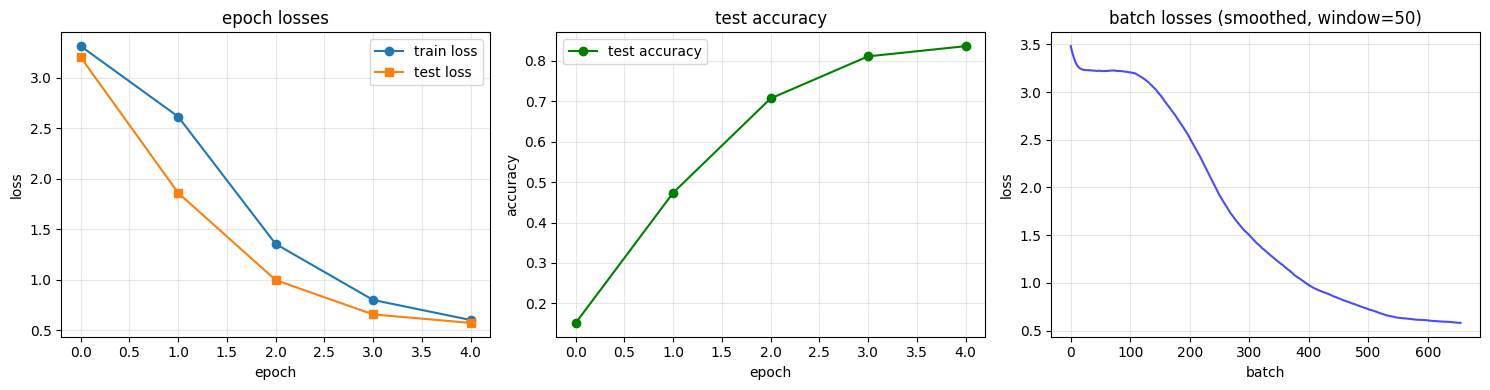


training complete!

training summary
best epoch: 5
best test loss: 0.5733
best test accuracy: 0.8364
final test loss: 0.5733
final test accuracy: 0.8364


In [24]:
# training hyperparameters
epochs = 5
lr = 1e-3
accumulation_steps = 1

# optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1, betas=(0.9, 0.95))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

# training monitor
monitor = TrainingMonitor()

print("="*60)
print("starting training")
print("="*60)
print(f"epochs: {epochs}")
print(f"learning rate: {lr}")
print(f"batch size: {batch_size}")
print(f"accumulation steps: {accumulation_steps}")
print("="*60)

best_loss = float('inf')

for epoch in range(epochs):
    print(f"\nepoch {epoch+1}/{epochs}")
    print("-" * 60)
    
    start = time.time()
    
    # train
    train_loss, batch_losses = train_epoch(
        model, train_loader, optimizer, device, 
        accumulation_steps=accumulation_steps, 
        print_every=5
    )
    
    # evaluate
    test_loss, test_acc = evaluate(model, test_loader, device)
    
    # update scheduler
    scheduler.step()
    
    # track metrics
    monitor.update(train_loss, test_loss, test_acc, batch_losses)
    
    elapsed = time.time() - start
    
    # save best model
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'trm_best.pt')
        print(f"  *** saved best model ***")
    
    print(f"\nepoch {epoch+1} summary:")
    print(f"  train_loss: {train_loss:.4f}")
    print(f"  test_loss: {test_loss:.4f}")
    print(f"  test_acc: {test_acc:.4f}")
    print(f"  time: {elapsed:.1f}s")
    
    # plot live updates
    monitor.plot(live=True)

print("\ntraining complete!")
monitor.print_summary()

## final visualization

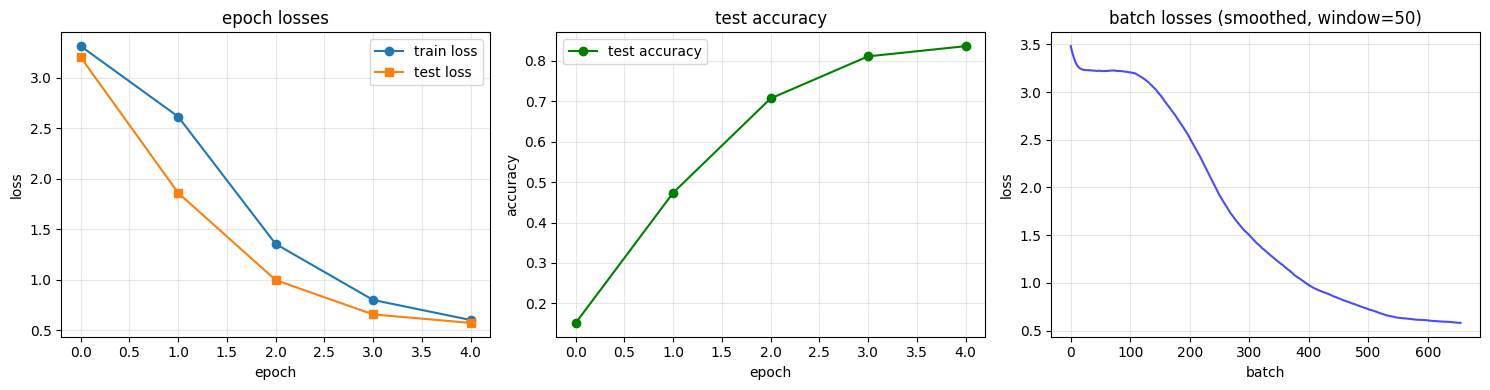

In [26]:
# plot final training curves
monitor.plot(live=False)

## load best model and evaluate

In [27]:
# load best model
model.load_state_dict(torch.load('trm_best.pt'))

# final evaluation
print("final evaluation on best model...")
test_loss, test_acc = evaluate(model, test_loader, device)
print(f"\nbest test loss: {test_loss:.4f}")
print(f"best test accuracy: {test_acc:.4f}")

final evaluation on best model...

best test loss: 0.5733
best test accuracy: 0.8364


## text generation

In [28]:
def generate_text(model, dataset, seed, max_len=300, temperature=0.8):
    """generate text from a seed string"""
    # encode seed
    seed_idx = [dataset.char_to_idx.get(c, 0) for c in seed]
    # pad to seq_len
    seed_idx = [0] * (seq_len - len(seed_idx)) + seed_idx
    seed_tensor = torch.tensor(seed_idx, dtype=torch.long, device=device)
    
    # generate
    generated_idx = model.generate(seed_tensor, max_len=max_len, temperature=temperature)
    generated_text = ''.join([dataset.idx_to_char.get(i, '?') for i in generated_idx])
    
    return generated_text

In [29]:
# generate with different seeds
seeds = ["ROMEO:", "JULIET:", "First Citizen:", "KING HENRY:"]
temperature = 0.8
max_len = 200

print("="*60)
print("text generation examples")
print("="*60)

for seed in seeds:
    print(f"\nseed: '{seed}'")
    print("-" * 60)
    
    generated = generate_text(model, dataset, seed, max_len=max_len, temperature=temperature)
    
    # find where seed ends in generated text
    seed_end = generated.find(seed) + len(seed)
    if seed_end > len(seed):
        print(generated[seed_end:seed_end+max_len])
    else:
        print(generated[-max_len:])
    
    print()

text generation examples

seed: 'ROMEO:'
------------------------------------------------------------

I iw'efet'l, iceniceil, pecipeleot or il ol
Tr tle' sl ten,
Alouspese icrousuote'e't
En te ,
As del h s ibleire l te es sby orju lle nesterey orgreatl t, lte teuousr k sr ir y tl to,
Wen-
Asbester te


seed: 'JULIET:'
------------------------------------------------------------
Nuoreluller tr h-
Ath ld ortn sit
Aeeilha s, l len telle
That ad
Thim s tha h spy orre t
Foll es tn yora dstre, hap
Ay otore
Wha le
USou sil oulel p' sueratr n; lomiglatsr sted t
Ah e-
ENtel olil oust


seed: 'First Citizen:'
------------------------------------------------------------
 flule letonel in ofisutr te i r-
Alyh te k sod tomusre d a pasl i-ne reste tat
Rilh
Thal a eisom be tenel le wel out
Alue s te
q tsrl -
Thit
kefe ters k louora
St'l hal tim al th tyileor?

Asr t'eon 


seed: 'KING HENRY:'
------------------------------------------------------------

Ayb ary tely use iter-
The-

Trl; hed iceel ou

## interactive generation

In [31]:
# interactive generation cell - run this to generate with custom seeds
custom_seed = "To be, or not to beee"  # change this!
custom_temp = 0.7  # change this (0.1 = conservative, 1.0 = creative)
custom_len = 300  # change this

print(f"seed: '{custom_seed}'")
print(f"temperature: {custom_temp}")
print(f"max length: {custom_len}")
print("\ngenerated text:")
print("=" * 60)

generated = generate_text(model, dataset, custom_seed, max_len=custom_len, temperature=custom_temp)
seed_end = generated.find(custom_seed) + len(custom_seed)
if seed_end > len(custom_seed):
    print(custom_seed + generated[seed_end:seed_end+custom_len])
else:
    print(generated[-custom_len:])

seed: 'To be, or not to beee'
temperature: 0.7
max length: 300

generated text:
To be, or not to beeeU' tel pyegrestre
Al- te tel nen te te aren trote y tnebi-or '- tel

That s k t
I s il pes, t
I l t
Al s,
Th eile,
Ol g'e-
Al;
Ousbel ilrat
Alale m
Trtoulle or tous, le pul st ore
Alod l st' teimus icousto,
Ahe lircor l tal ice trwo le st'heu
Th ane y or,
Cin:
Ateuster o'st le' it
Apeh iln:
Alt-
Fil


## model analysis

In [35]:
# analyze model predictions on test samples
model.eval()

# get a batch from test set
test_iter = iter(test_loader)
x, y = next(test_iter)
x, y = x.to(device), y.to(device)

# get predictions
with torch.no_grad():
    logits = model(x)
    preds = logits.argmax(dim=-1)

# show first few examples
num_examples = 10
print("="*60)
print("prediction examples")
print("="*60)

for i in range(num_examples):
    input_text = ''.join([dataset.idx_to_char[idx.item()] for idx in x[i]])
    target_text = ''.join([dataset.idx_to_char[idx.item()] for idx in y[i]])
    pred_text = ''.join([dataset.idx_to_char[idx.item()] for idx in preds[i]])
    
    # calculate accuracy for this sequence
    acc = (preds[i] == y[i]).float().mean().item()
    
    print(f"\nexample {i+1}:")
    print(f"input:  {input_text}")
    print(f"target: {target_text}")
    print(f"pred:   {pred_text}")
    print(f"accuracy: {acc:.2%}")
    print("-" * 60)

prediction examples

example 1:
input:  y was deliberate,
Not rash like 
target:  was deliberate,
Not rash like h
pred:    was deliberate,
Not rush fibe t
accuracy: 87.50%
------------------------------------------------------------

example 2:
input:  nius Agrippa; one that hath alwa
target: ius Agrippa; one that hath alway
pred:   ius egritlas one that hath sltal
accuracy: 78.12%
------------------------------------------------------------

example 3:
input:  ost wise rebellion, thou go'st f
target: st wise rebellion, thou go'st fo
pred:   st wice retepdion, thou gorst f 
accuracy: 81.25%
------------------------------------------------------------

example 4:
input:  ide more
piercing statutes daily
target: de more
piercing statutes daily,
pred:   de bore
Yiercing statutes de ry 
accuracy: 81.25%
------------------------------------------------------------

example 5:
input:  ole body. The belly answer'd--


target: le body. The belly answer'd--

F
pred:   fe bods, The belis arstera